# 한국어 뉴스기사 분류

## 한국어 뉴스기사 범주 분류기 만들기

- 자료실에 있는 BalancedNewsCorpus_train.csv, BalancedNewsCorpus_test.csv는 국어원 뉴스 자료에서 9개 분야의 신문별 균형을 맞춘 자료로, 학습용 9,000개 시험용 1800 자료가 있는 파일이다.
- 이 파일을 가지고 https://github.com/bentrevett/pytorch-sentiment-analysis 에 있는 pytorch sentiment analysis의 방법을 따라 한국어 뉴스기사 분류기를 만들기

## 목표

- csv 파일을 읽어서 torchtext를 사용하여 데이터를 신경망에 입력가능한 꼴로 바꾸기
(Field, Iterator, train,test, evaluation and prediction)
- 한국어 데이터 전처리를 위한 함수를 만들고 이를 torchtext에 통합하기 

- 외부에서 학습된 한국어 단어 임베딩을 torchtext에 통합하여 사용하기 (word2vec, glove, fasttext 중 골라서 사용)
- 제시된 여러 모델을 사용하여(transformers 제외) 성능을 향상 시키기
- training, evaluation 한 것을 test 데이터에 적용하여 성능을 보이기.
- predict를 사용하여 제시된 기사들의 분류 결과를 보이기

- 참고 사이트
    - https://pytorch.org/text/
    - http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/
    - https://github.com/pytorch/text
    - https://mc.ai/using-fine-tuned-gensim-word2vec-embeddings-with-torchtext-and-pytorch/

## 이 자료를 위해 사전학습된 임베딩
- 필요에 따라 선택하여 사용할 수 있음

### Word2vec 모델
 - 노트 : https://drive.google.com/file/d/1KOv901TPv5gepEdd4cCsJWoCHVaAV-A-/view?usp=sharing
 - Word2Vec 형태소 모델 : https://drive.google.com/file/d/1DDx6lRSTVULRFP3kslQLZsuoGZJOtoR1/view?usp=sharing
 - Word2Vec 어절 모델 : https://drive.google.com/file/d/1-RuEk-MhULduAbizgt3wjsMOCL3sM_pl/view?usp=sharing

- from gensim.models.keyedvectors import KeyedVectors
- Word2Vec_300D_space_model = KeyedVectors.load_word2vec_format(path + 'Word2Vec_300D_space.model', binary=False, encoding='utf-8')


### Fasttext 모델

- fasttext 형태소 모델: https://drive.google.com/file/d/1-EBaAtFK7chB6qqckKmLdghR62SebEYK/view?usp=sharing
- fasttext 어절 모델: https://drive.google.com/file/d/1-0D7Fe5oG_z9pQqOjkewtsuV_uVkh_dF/view?usp=sharing
- fasttext 형태소 자모 모델: https://drive.google.com/file/d/1-WW_qWQZ2q3Jj9fXXex82dYHWIMHGVri/view?usp=sharing
- fasttext 어절 자모 모델: https://drive.google.com/file/d/1-P2b8Dp09fZYO2Y__wjPNmS77PF7kfqV/view?usp=sharing


- from gensim.models.keyedvectors import KeyedVectors
- fasttext_model2 = KeyedVectors.load_word2vec_format(path + 'fasttext_morph_300.model', binary=False, encoding='utf-8')

### Glove 모델

- https://drive.google.com/drive/folders/1pzVO0jwx1Zf8p4hjf4JQn81XWzktsIdg?usp=sharing 


- from gensim.models.keyedvectors import KeyedVectors
- Glove_model = KeyedVectors.load_word2vec_format(# 모델 경로 , binary=False, encoding='utf-8')


## 코드 개요

* 필요한 라이브러리 설치 및 불러오기
* 뉴스기사 데이터 불러오기, 데이터 전처리
* 분류 모델 구축하기
* 분류 모델 학습하기
* 학습한 분류 모델 테스트하기

## 1. 필요한 라이브러리 준비하기

In [ ]:
# 설치되어 있지 않은 라이브러리 설치
# !pip install torchtext
# !pip install gensim
!pip install --ignore-installed hanja

# !apt-get update
# !apt-get install g++ openjdk-8-jdk python-dev python3-dev
# !pip install JPype1-py3
!pip install konlpy
# !JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"

# !sudo apt-get install curl
# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

# 라이브러리 불러오기
import numpy as np
import pandas as pd
import re, hanja

import torch, torchtext
from torchtext.legacy import data, datasets
import konlpy
from konlpy.tag import Okt # Kkma, Komoran, Mecab 등 다른 종류의 형태소분석기 사용 가능

import random
SEED = 1234

from torchtext.vocab import Vectors
from gensim.models.keyedvectors import KeyedVectors

import numpy as np

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import time

Processing /root/.cache/pip/wheels/45/fc/c9/b7e7cb5c86935a1a99e2ad07f763728f8f17560e7b815a4b27/hanja-0.13.3-cp37-none-any.whl
  Using cached https://files.pythonhosted.org/packages/4f/c1/4338af20641814915f6970b6baa89deabe2b1b83f961fd0ef0cbfb0638a1/coveralls-3.1.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a1/59/6821e900592fbe261f19d67e4def0cb27e52ef8ed16d9922c144961cc1ee/pytest-6.2.4-py3-none-any.whl
Processing /root/.cache/pip/wheels/d9/45/dd/65f0b38450c47cf7e5312883deb97d065e030c5cca0a365030/PyYAML-5.1.2-cp37-cp37m-linux_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/ba/84/576b071aef9ac9301e5c0ff35d117e12db50b87da6f12e745e9c5f745cc2/pytest_cov-2.12.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/16/e0/fc9f7bd9b84e6b41d0aad1a113e36714aac0c0a9b307aca5f9af443bc50f/coverage-5.5-cp37-cp37m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/29/c1/24814557f1d22c56d50280771a17307e6b

## 2. 데이터 전처리 준비

In [ ]:
# 토큰화 전 텍스트 내 불필요한 문자를 제거하는 함수
# 여기서는 정규표현식(regular expression) 이용

def cleanse_sentence(sent): 
    
    # 문장 내 한자 제거
    if re.search("[\u2E80-\u2FD5\u3190-\u319f\u3400-\u4DBF\u4E00-\u9FCC\uF900-\uFAAD]", sent) is not None:
        sent = hanja.translate(sent, 'substitution')
        
    # 문장 내 특수기호 제거
    sent = (r'\[[^\]]+\]|\([^\)]+\)|\<[^\>]+\>', '', str(sent))
    sent = re.sub("[.,!?||]", " ", str(sent))
    sent = re.sub(r'[^가-힣|\s]', '', str(sent))
    sent = re.sub(r'\s+', ' ', str(sent)) 
    
    return sent.rstrip()


# 문장 토큰화 함수
def tokenizer(text):
    okt = Okt()
    morphs_tokenized = []
    for string in text:
        # 위 함수를 적용하여 불필요한 한자, 특수기호 등 제거
        string = cleanse_sentence(string)
        # 미처 제거되지 못한 특수기호 마저 제거
        string.replace("…","")
        string.replace("ㆍ","")
        # 형태소 분석기를 적용하여 문장 토큰화
        morphs = okt.morphs(string)
        # 분석된 토큰들 중 길이가 1보다 긴 것들만을 결과에 포함
        morphs = [a for a in morphs if len(a) > 1]
        morphs_tokenized += morphs
        
    return morphs_tokenized
        

## 3. torchtext를 이용해 데이터 불러오기

### torchtext: PyTorch가 제공하는 텍스트 관련 기능들을 모은 라이브러리
* from torchtext.legacy import data, datasets
* from torchtext.vocab import Vectors 등
* 파일 로드하기, 토큰화(tokenization), 사전(vocab) 구성, 단어->정수(integer) 인코딩, 단어 벡터 구성, 배치화(batching) 등
* 주로 위에서 import한 'data'에서 하위 메서드를 불러와서 사용할 것임 (TabularDataset, BucketIterator 등)

In [ ]:
!wget http://knlp.snu.ac.kr/hpshin/BalancedNewsCorpusShuffled.zip
!unzip BalancedNewsCorpusShuffled.zip -d BalancedNewsCorpusShuffled

--2021-06-14 12:16:08--  http://knlp.snu.ac.kr/hpshin/BalancedNewsCorpusShuffled.zip
Resolving knlp.snu.ac.kr (knlp.snu.ac.kr)... 147.46.33.123
Connecting to knlp.snu.ac.kr (knlp.snu.ac.kr)|147.46.33.123|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11752896 (11M) [application/zip]
Saving to: ‘BalancedNewsCorpusShuffled.zip’

BalancedNewsCorpusS 100%[===================>]  11.21M   651KB/s    in 23s     

2021-06-14 12:16:32 (492 KB/s) - ‘BalancedNewsCorpusShuffled.zip’ saved [11752896/11752896]

Archive:  BalancedNewsCorpusShuffled.zip
  inflating: BalancedNewsCorpusShuffled/BalancedNewsCorpus_train.csv  
  inflating: BalancedNewsCorpusShuffled/BalancedNewsCorpus_test.csv  


In [ ]:
# 데이터 예시
temp_df = pd.read_csv('BalancedNewsCorpusShuffled/BalancedNewsCorpus_test.csv', encoding='utf-8')
temp_df.head(5)

,filename,date,NewsPaper,Topic,News
0,NLRW1900000024,20120209,경기일보,IT/과학,"<p> 인터넷 게임 족쇄에 도내 업체도 ‘덜덜’ </p> <p> 道ㆍ업체 ""긍정적인..."
1,NLRW1900000029,20171018,경기일보,IT/과학,"<p> 삼성전자, UN에 삼성만의 특화된 생태 보전 활동 자랑하다생물다양성 보존활동..."
2,NLRW1900000029,20170920,경기일보,IT/과학,"<p> 지자체의 ‘카카오채널’, 도민들 관심 부족으로 폐쇄되거나 운영 부실 </p>..."
3,NLRW1900000025,20130218,경기일보,IT/과학,"<p> 돈만 잡아먹는 홈페이지, 과감하게 ‘로그아웃’ </p> <p> 경기도가 연간..."
4,NLRW1900000028,20160314,경기일보,IT/과학,<p> 콘텐츠기업 대상 ‘부천 클러스터’ 입주사 모집 </p> <p> 경기콘텐츠진흥...


In [ ]:
# torchtext 필드 선언
# 필드: 데이터에 대해 앞으로 어떤 전처리를 할 것인지 정의하기 위한 도구
TEXT = data.Field(preprocessing=tokenizer, include_lengths=True, batch_first=True, sequential=True)
LABEL = data.LabelField(dtype=torch.long)

data_fields = [("filename", None), ("date", None), ("NewsPaper", None), ('Topic', LABEL), ('News', TEXT)]

# 데이터 불러오기
train_data, test_data = data.TabularDataset.splits(path ='BalancedNewsCorpusShuffled', 
                                                   train='BalancedNewsCorpus_train.csv',
                                                   test='BalancedNewsCorpus_test.csv',
                                                   format='csv',
                                                   fields=data_fields,
                                                   skip_header=True
                                                  )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Possible set union at position 5
  if sys.path[0] == '':


In [ ]:
print('NUMBER of TRAIN data:', len(train_data))
print('NUMBER of TEST data:', len(test_data))

NUMBER of TRAIN data: 9000
NUMBER of TEST data: 1800


In [ ]:
# 아래 분류 모델에서 사용할 수 있는 형태로 변환
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, test_iterator = data.BucketIterator.splits((train_data, test_data), 
                                                           sort_key=lambda x: len(x.News),
                                                          sort_within_batch=False,
                                                           repeat=False,
                                                          batch_size=BATCH_SIZE, 
                                                           device=device)

### 토큰화된 기사 예시

In [ ]:
# training data의 4번째 데이터 확인
print(vars(train_data.examples[3]))

{'Topic': '스포츠', 'News': ['모처럼', '살아난', '타점', '합작', '진입', '놓고', '혈전', '벌이', '있는', '와의', '나무', '다리', '결투', '먼저', '웃었다', '광주', '구장', '에서', '열린', '프로야구', '와의', '시즌', '차전서', '김상현', '최희섭', '홈런', '포함', '장단', '안타', '퍼부은', '선의', '활약', '입어', '으로', '완승', '연승', '달렸다', '시즌', '전적', '승리', '치고', '위로', '올라섰다', '두산', '꺾은', '롯데', '와는', '기차', '유지', '됐다', '지난', '시즌', '한국', '시리즈', '우승', '원동력', '하나', '였던', '김상현', '최희섭', '쌍포', '가동', '으로', '부활', '알렸다', '김상현', '지난달', '롯데', '복귀전', '홈런', '이후', '경기', '만에', '대포', '가동', '하는', '안타', '타점', '최희섭', '지난달', '롯데', '이후', '경기', '만에', '홈런', '신고', '하는', '안타', '타점', '기록', '둘이서', '타점', '합작', '하며', '승리', '이끌었다', '선발', '등판', '양현종', '이닝', '동안', '안타', '탈삼진', '실점', '으로', '시즌', '승패', '기록', '하며', '역시', '올린', '한화', '류현진', '함께', '동위', '자리', '지켰다', '통쾌한', '선제', '포로', '초반', '기선', '제압', '했다', '회말', '선두', '타자', '최희섭', '볼넷', '골라', '출루', '타석', '나선', '김상현', '상대', '선발', '김광삼', '슬라이더', '통타', '좌측', '담장', '넘기는', '투런아치호', '쏘아', '올리며', '선취', '안겼다', '하지만', '리드', '잠시', '회초', '볼넷', '실책', '으로', '내준', '이

### 데이터 본문을 이루는 단어들로 사전 구성

In [ ]:
MAX_VOCAB_SIZE = 25_000

# 본문 사전 구성
TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)

# label (뉴스 기사 범주) 사전 구성
LABEL.build_vocab(train_data)

In [ ]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', '으로', '했다', '에서', '하는', '이다', '있다', '하고', '있는']


In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'IT/과학': 0, '경제': 1, '문화': 2, '미용/건강': 3, '사회': 4, '생활': 5, '스포츠': 6, '연예': 7, '정치': 8})


## 4. 사전학습된 임베딩 모델 불러오기
### FastText 형태소 모델 사용

In [ ]:
# 미리 저장해 둔 FastText 모델 불러오기
# FastText 모델 다운로드 -> colab 런타임에 업로드
from gensim.models.keyedvectors import KeyedVectors
fasttext_model = KeyedVectors.load_word2vec_format('fasttext_morph_300.model', binary=False, encoding='utf-8')

In [ ]:
i = 0
w2vec = []
# 위에서 구성한 본문 사전에 있는 단어들에 FastText 임베딩을 매칭시키는 과정
for token, idx in TEXT.vocab.stoi.items():
    # if token in fasttext_model.key_to_index.keys():  
    if token in fasttext_model.vocab.keys():  # gensim 3.x까지는 fasttext_model.vocab.keys()
        w2vec.append(fasttext_model[token])  
        i+=1
    else:
        # 단어가 FastText 임베딩 모델에 없는 단어일 경우 랜덤한 300개의 숫자로 임베딩을 구성
        w2vec.append(0.01*np.random.randn(300))

pretrained_embeddings = torch.FloatTensor(w2vec)
print('Total NUMBER of VOCABS:', i)

Total NUMBER of VOCABS: 14356


In [ ]:
# 위에서 설정한 25,000개의 단어와 <pad>, <unk>를 합하여 25,002개의 단어의 임베딩을 얻음
print(pretrained_embeddings.shape)

torch.Size([25002, 300])


## 5. 기사 분류 모델 구축하기
### 5.1. RNN 모델 사용 

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, 
                           dropout=dropout, batch_first=True)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        embedded = self.dropout(self.embedding(text))

        output, (hidden, cell) = self.rnn(embedded)
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        return self.fc(hidden)

In [ ]:
# Model hyper-parameters

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 9  # 정답 범주(label)의 개수
N_LAYERS = 1 
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model_rnn = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


### 위 4에서 구성한 단어 임베딩을 RNN 모델에 결합

In [ ]:
model_rnn.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-8.3752e-04,  9.9318e-03, -3.0366e-03,  ..., -1.2378e-02,
          4.2520e-03, -1.1243e-02],
        [-2.4911e-02,  1.9219e-02,  2.2654e-02,  ..., -6.7820e-04,
          8.6682e-03, -4.9253e-03],
        [-3.5333e-01, -1.3169e+00,  8.0137e-01,  ...,  2.7663e-01,
         -4.8837e-01, -1.1233e-02],
        ...,
        [ 3.6000e-03,  1.0463e-05, -2.8822e-03,  ..., -5.0827e-03,
          4.1577e-04, -1.6127e-03],
        [ 6.4252e-03, -2.4886e-02,  1.4063e-02,  ...,  6.7811e-03,
         -7.0167e-03,  1.5517e-02],
        [ 7.9713e-04,  8.1465e-03, -6.4202e-03,  ...,  1.0091e-02,
          4.5842e-03, -6.0374e-03]])

In [ ]:
# UNK, PAD 토큰 처리 (zero vector로 초기화)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model_rnn.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model_rnn.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [ ]:
# 분류 모델이 학습하는 패러미터의 수

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model_rnn):,} trainable parameters')

The model has 8,648,001 trainable parameters


### 분류 모델 학습, 평가하기

In [ ]:
# 학습의 속도, 안정성 등을 최적화하기 위한 optimizer 설정
optimizer = optim.Adam(model_rnn.parameters())

# GPU가 있다면 GPU에서 모델 학습 및 평가 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# 모델의 성능을 평가하기 위해 cross entropy loss 사용
criterion = nn.CrossEntropyLoss()

# 분류 모델과 loss 모델을 GPU(또는 CPU)에 세팅
model_rnn = model_rnn.to(device)
criterion = criterion.to(device)

cuda


In [ ]:
# 모델 학습을 위한 함수
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    total = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        batch.News = batch.News[0].cuda()
        batch.Topic = batch.Topic.cuda()
        
        predictions = model(batch.News).squeeze(1)
        
        loss = criterion(predictions, batch.Topic)

        _, predicted = torch.max(predictions.data, 1)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        total += batch.Topic.size(0)
        epoch_acc += (predicted == batch.Topic).sum().item()
        
    return epoch_loss, epoch_acc / total

In [ ]:
# 모델 평가를 위한 함수
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    total = 0
    
    model.eval()

    with torch.no_grad():
        for batch in iterator:
            batch.News = batch.News[0].cuda()
            batch.Topic = batch.Topic.cuda()
            predictions = model(batch.News).squeeze(1)
            
            loss = criterion(predictions, batch.Topic)
            
            _, predicted = torch.max(predictions.data, 1)

            epoch_loss += loss.item()
            total += batch.Topic.size(0)
            epoch_acc += (predicted == batch.Topic).sum().item()
        
    return epoch_loss, epoch_acc / total

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 20

best_test_loss = float('inf')
best_test_acc = 0

train_loss = [0 for i in range(N_EPOCHS)]
train_acc =[0 for i in range(N_EPOCHS)]
test_loss = [0 for i in range(N_EPOCHS)]
test_acc = [0 for i in range(N_EPOCHS)]

i = 0

for epoch in range(N_EPOCHS):

    start_time = time.time()

    # training data를 이용해 모델 학습
    train_loss[i], train_acc[i] = train(model_rnn, train_iterator, optimizer, criterion)
    # test data를 이용해 모델 평가
    test_loss[i], test_acc[i] = evaluate(model_rnn, test_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # 모델 평가: 각 epoch에서 얻은 최고 성능을 저장
    if test_loss[i] < best_test_loss:
        best_test_loss = test_loss[i]
    
    if test_acc[i] > best_test_acc:
        best_test_acc = test_acc[i]
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss[i]:.3f} | Train Acc: {train_acc[i]*100:.2f}%')
    print(f'\t Test Loss: {test_loss[i]:.3f} |  Test Acc: {test_acc[i]*100:.2f}%')

    i+=1

Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 204.522 | Train Acc: 51.32%
	 Test Loss: 64.635 |  Test Acc: 36.89%
Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 160.049 | Train Acc: 62.54%
	 Test Loss: 43.754 |  Test Acc: 58.33%
Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 133.125 | Train Acc: 69.19%
	 Test Loss: 44.340 |  Test Acc: 56.83%
Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 96.321 | Train Acc: 77.51%
	 Test Loss: 47.827 |  Test Acc: 61.83%
Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 100.906 | Train Acc: 76.14%
	 Test Loss: 58.159 |  Test Acc: 46.83%
Epoch: 06 | Epoch Time: 0m 9s
	Train Loss: 75.854 | Train Acc: 82.07%
	 Test Loss: 54.981 |  Test Acc: 51.89%
Epoch: 07 | Epoch Time: 0m 9s
	Train Loss: 61.659 | Train Acc: 85.59%
	 Test Loss: 52.356 |  Test Acc: 54.44%
Epoch: 08 | Epoch Time: 0m 9s
	Train Loss: 51.714 | Train Acc: 88.13%
	 Test Loss: 51.010 |  Test Acc: 56.06%
Epoch: 09 | Epoch Time: 0m 9s
	Train Loss: 42.168 | Train Acc: 90.73%
	 Test Loss: 49.790 |  Test Acc: 61.28%
Epoch:

In [ ]:
rnn_results = [test_loss, train_loss, test_acc, train_acc]

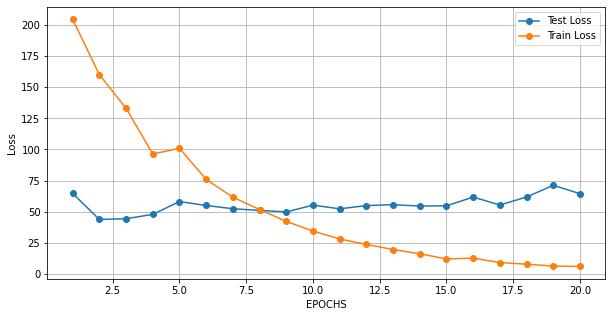

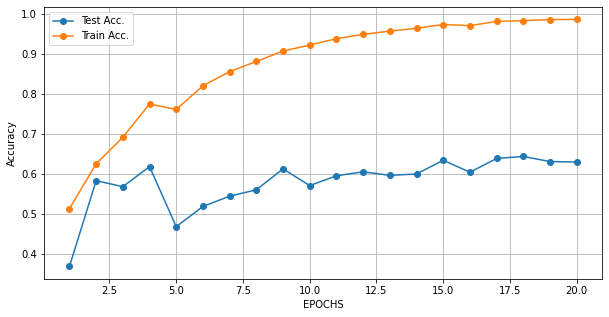

Best Test Acc: 64.39%    (Test Loss: 43.754)


In [ ]:
import matplotlib.pyplot as plt

def P_graph(test_loss, train_loss, test_acc, train_acc):
    plt.figure(figsize=(10, 5))
    x = range(1,N_EPOCHS+1)
    y_te = test_loss
    plt.plot(x,y_te,marker='o',label='Test Loss')
    y_tr = train_loss
    plt.plot(x,y_tr,marker='o',label='Train Loss')
    plt.xlabel("EPOCHS")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()   
    
    plt.figure(figsize=(10, 5))
    x = range(1,N_EPOCHS+1)
    y_te = test_acc
    plt.plot(x,y_te,marker='o',label='Test Acc.')
    y_tr = train_acc
    plt.plot(x,y_tr,marker='o',label='Train Acc.')
    plt.xlabel("EPOCHS")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

P_graph(rnn_results[0], rnn_results[1], rnn_results[2], rnn_results[3])
print(f'Best Test Acc: {best_test_acc*100:.2f}%    (Test Loss: {best_test_loss:.3f})')

### 분류 모델 테스트

In [ ]:
def predict_news(model, sentence, min_len=5):
    model.eval()

    tokenized = [tok for tok in tokenizer(sentence.split())]
    
    if len(tokenized) < min_len:
      tokenized += ['<pad>'] * (min_len - len(tokenized))

    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).unsqueeze(0).to(device)
    prediction = torch.sigmoid(model(tensor))
    out = torch.mean(prediction, 0)
    news_label = torch.max(out, 0)
    
    return {'Predicted Label': LABEL.vocab.itos[int(news_label.indices)], 'Sentence': sentence}

In [ ]:
sentence = []
sentence.append("차진 식감과 부드러운 감촉을 모두 지닌 식빵, 결결이 찢어지는 크루아상, 둥글고 크게 구운 호밀빵 모두 모양새부터 알차고 단단했다. 디저트로 눈을 옮기면 국가 대표팀같이 뭐 하나 빼놓을 수 없는 케이크가 나란히 줄을 서 있었다.")
sentence.append("정부는 2012년 예산의 공고안과 배정계획을 1월3일 국무회의에서 의결하고 연초부터 바로 집행에 들어간다. 세계 경제의 불확실성이 높아지고 경기가 둔화할 가능성이 높은 만큼 조기 집행에 박차를 가할 예정이다")
sentence.append("국세청은 특히 서민생활에 피해를 주면서 폭리를 취하는 매점매석 농수산물 유통업체 등에 대한 추적조사를 강화하고, 지방청에 ‘민생침해 사업자 조사전담팀’을 꾸려 민생침해 탈세자에 대한 엄정 대응에 나설 계획이라고 밝혔다")
sentence.append("26일 제25회 부산국제영화제 갈라 프레젠테이션 부문 초청작 '스파이의 아내' 온라인 기자회견이 진행됐다. 작품을 연출한 구로사와 감독이 참석해 작품에 대한 이야기를 나눴다.")
sentence.append("70대 운전사가 몰던 25인승 어린이 통학버스가 주유소로 돌진해 차량 3대를 들이 받았다. 다행히 통학버스에 운전자 외에는 탑승자가 없어 큰 인명피해는 피했다. 운전자는 차량 결함을 주장하고 있으나, 경찰은 운전자 과실 여부도 조사 중이다.")
sentence.append("토트넘이 손흥민에게 주급 20만 파운드(약 3억원)-5년 재계약을 제안할 준비를 마쳤다.' 25일(한국시각) 영국 대중일간 더선의 헤드라인이다. 조제 무리뉴 토트넘 감독이 번리전을 앞두고 기자회견을 통해 구단에 토트넘에서의 손흥민의 장밋빛 미래를 확신하며 재계약을 요청한 직후 영국 현지 언론에선 손흥민 재계약 보도가 쏟아지고 있다.")
sentence.append("공연은 말 그대로 다채로움 그 자체였다. 발레극인지, 현대무용극인지, 전통극인지, 연극인지, 연극이면 다인극인지 1인극인지 모를 정도로 다양한 장르의 결합이 먼저 눈에 띈다.")
sentence.append("발이 아프면 걷는 자세가 나빠지고 자연스럽게 무릎, 골반, 허리에 이상이 생길 수 있다. 이를 예방하려면 평소 발바닥 근육을 스트레칭하고 강화하는 운동을 지속하는 게 중요하다.")
sentence.append("전기차 화재 사고가 연이어 발생하는 가운데 불타지 않는 SK이노베이션 배터리가 주목받는다. SK이노베이션의 배터리는 글로벌 배터리 업체 중 유일하게 단 한건의 화재도 일어나지 않았다. 이같은 비결이 자동차 안정성을 결정짓는 분리막 내재화에 있다는 평가가 나온다.")

raw_data = {'Labels': ['생활','정치','경제','문화','사회','스포츠','연예','미용/건강','IT/과학']}

print(predict_news(model_rnn, sentence[0]))
print(predict_news(model_rnn, sentence[1]))
print(predict_news(model_rnn, sentence[2]))


{'Predicted Label': '생활', 'Sentence': '차진 식감과 부드러운 감촉을 모두 지닌 식빵, 결결이 찢어지는 크루아상, 둥글고 크게 구운 호밀빵 모두 모양새부터 알차고 단단했다. 디저트로 눈을 옮기면 국가 대표팀같이 뭐 하나 빼놓을 수 없는 케이크가 나란히 줄을 서 있었다.'}
{'Predicted Label': '경제', 'Sentence': '정부는 2012년 예산의 공고안과 배정계획을 1월3일 국무회의에서 의결하고 연초부터 바로 집행에 들어간다. 세계 경제의 불확실성이 높아지고 경기가 둔화할 가능성이 높은 만큼 조기 집행에 박차를 가할 예정이다'}
{'Predicted Label': '사회', 'Sentence': '국세청은 특히 서민생활에 피해를 주면서 폭리를 취하는 매점매석 농수산물 유통업체 등에 대한 추적조사를 강화하고, 지방청에 ‘민생침해 사업자 조사전담팀’을 꾸려 민생침해 탈세자에 대한 엄정 대응에 나설 계획이라고 밝혔다'}


In [ ]:
# 위의 결과를 표(DataFrame)로 나타내기

result = pd.DataFrame(raw_data)

df = pd.DataFrame()
for s in sentence:
  df = df.append(predict_news(model_rnn, s), ignore_index=True)

result = pd.concat([result,df],axis=1, join='inner')

Accuracy = sum((result['Labels'] == result['Predicted Label'])==True)/len(result) * 100

print("Accuracy = ",round(Accuracy,2),"%")

result

Accuracy =  44.44 %


,Labels,Predicted Label,Sentence
0,생활,생활,"차진 식감과 부드러운 감촉을 모두 지닌 식빵, 결결이 찢어지는 크루아상, 둥글고 크..."
1,정치,경제,정부는 2012년 예산의 공고안과 배정계획을 1월3일 국무회의에서 의결하고 연초부터...
2,경제,사회,국세청은 특히 서민생활에 피해를 주면서 폭리를 취하는 매점매석 농수산물 유통업체 등...
3,문화,문화,26일 제25회 부산국제영화제 갈라 프레젠테이션 부문 초청작 '스파이의 아내' 온라...
4,사회,생활,70대 운전사가 몰던 25인승 어린이 통학버스가 주유소로 돌진해 차량 3대를 들이 ...
5,스포츠,스포츠,토트넘이 손흥민에게 주급 20만 파운드(약 3억원)-5년 재계약을 제안할 준비를 마...
6,연예,문화,"공연은 말 그대로 다채로움 그 자체였다. 발레극인지, 현대무용극인지, 전통극인지, ..."
7,미용/건강,미용/건강,"발이 아프면 걷는 자세가 나빠지고 자연스럽게 무릎, 골반, 허리에 이상이 생길 수 ..."
8,IT/과학,경제,전기차 화재 사고가 연이어 발생하는 가운데 불타지 않는 SK이노베이션 배터리가 주목...


### 5.2. CNN 모델 사용

In [ ]:
# 3-layer CNN 모델 구성
class CNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_filters, filter_size, output_dim, dropout, pad_idx):
        super().__init__()
        
        # 룩업테이블
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        
        # cnn layers
        self.conv_0 = nn.Conv2d(in_channels=1,
                               out_channels=n_filters,
                               kernel_size=(filter_size[0], embed_dim))
        
        self.conv_1 = nn.Conv2d(in_channels=1,
                               out_channels=n_filters,
                               kernel_size=(filter_size[1], embed_dim))
        
        self.conv_2 = nn.Conv2d(in_channels=1,
                               out_channels=n_filters,
                               kernel_size=(filter_size[2], embed_dim))
        
        self.norm0 = nn.BatchNorm1d(n_filters)
        self.norm1 = nn.BatchNorm1d(n_filters)
        self.norm2 = nn.BatchNorm1d(n_filters) 
        
        self.prelu0 = nn.PReLU(n_filters)
        self.prelu1 = nn.PReLU(n_filters)
        self.prelu2 = nn.PReLU(n_filters)
        
        self.fc = nn.Linear(len(filter_size) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    # x 모양 : [batch_size, sent length]
    def forward(self, x):
        
        # word_embedding : [batch-size, sent_length, embed_dim]
        word_embedding = self.embedding(x)     
        
        # [batch_size, 1, sent_length, embed dim ]
        word_embedding = word_embedding.unsqueeze(1)
        
        # [batch size, n_filters, sent len - filter_sizes[n] + 1]
        conved_0 = F.relu(self.norm0(self.conv_0(word_embedding).squeeze(3)))
        conved_1 = F.relu(self.norm1(self.conv_1(word_embedding).squeeze(3)))        
        conved_2 = F.relu(self.norm2(self.conv_2(word_embedding).squeeze(3)))        
        
        #pooled_n = [batch size, n_filters]
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        # cat = [batch size, n filters * len(filter size)]
        concat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))
        scores = self.fc(concat)
        return scores        

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBED_DIM = 300
N_FILTERS = 128
FILTER_SIZE = [5, 6, 7]
OUTPUT_DIM = 9
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model_cnn = CNN(INPUT_DIM, EMBED_DIM, N_FILTERS, FILTER_SIZE, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [ ]:
# 위 4에서 구성한 단어 임베딩을 RNN 모델에 결합
model_cnn.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-8.3752e-04,  9.9318e-03, -3.0366e-03,  ..., -1.2378e-02,
          4.2520e-03, -1.1243e-02],
        [-2.4911e-02,  1.9219e-02,  2.2654e-02,  ..., -6.7820e-04,
          8.6682e-03, -4.9253e-03],
        [-3.5333e-01, -1.3169e+00,  8.0137e-01,  ...,  2.7663e-01,
         -4.8837e-01, -1.1233e-02],
        ...,
        [ 3.6000e-03,  1.0463e-05, -2.8822e-03,  ..., -5.0827e-03,
          4.1577e-04, -1.6127e-03],
        [ 6.4252e-03, -2.4886e-02,  1.4063e-02,  ...,  6.7811e-03,
         -7.0167e-03,  1.5517e-02],
        [ 7.9713e-04,  8.1465e-03, -6.4202e-03,  ...,  1.0091e-02,
          4.5842e-03, -6.0374e-03]])

In [ ]:
# UNK, PAD 토큰 처리 (zero vector로 초기화)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model_cnn.embedding.weight.data[UNK_IDX] = torch.zeros(EMBED_DIM)
model_cnn.embedding.weight.data[PAD_IDX] = torch.zeros(EMBED_DIM)

In [ ]:
# 분류 모델이 학습하는 패러미터의 수
print(f'The model has {count_parameters(model_cnn):,} trainable parameters')

The model has 8,196,801 trainable parameters


### 분류 모델 학습, 평가하기

In [ ]:
# 학습의 속도, 안정성 등을 최적화하기 위한 optimizer 설정
optimizer = optim.Adam(model_cnn.parameters())

# GPU가 있다면 GPU에서 모델 학습 및 평가 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델의 성능을 평가하기 위해 cross entropy loss 사용
criterion = nn.CrossEntropyLoss()

# 분류 모델과 loss 모델을 GPU(또는 CPU)에 세팅
model_cnn = model_cnn.to(device)
criterion = criterion.to(device)

In [ ]:
N_EPOCHS = 20

best_test_loss = float('inf')
best_test_acc = 0

train_loss = [0 for i in range(N_EPOCHS)]
train_acc =[0 for i in range(N_EPOCHS)]
test_loss = [0 for i in range(N_EPOCHS)]
test_acc = [0 for i in range(N_EPOCHS)]

i = 0

for epoch in range(N_EPOCHS):

    start_time = time.time()

    # training data를 이용해 모델 학습
    train_loss[i], train_acc[i] = train(model_cnn, train_iterator, optimizer, criterion)
    # test data를 이용해 모델 평가
    test_loss[i], test_acc[i] = evaluate(model_cnn, test_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # 모델 평가: 각 epoch에서 얻은 최고 성능을 저장
    if test_loss[i] < best_test_loss:
        best_test_loss = test_loss[i]
    
    if test_acc[i] > best_test_acc:
        best_test_acc = test_acc[i]
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss[i]:.3f} | Train Acc: {train_acc[i]*100:.2f}%')
    print(f'\t Test Loss: {test_loss[i]:.3f} |  Test Acc: {test_acc[i]*100:.2f}%')

    i+=1

Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 236.738 | Train Acc: 50.51%
	 Test Loss: 22.474 |  Test Acc: 72.94%
Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 137.242 | Train Acc: 67.64%
	 Test Loss: 20.104 |  Test Acc: 75.17%
Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 112.190 | Train Acc: 73.02%
	 Test Loss: 19.529 |  Test Acc: 76.17%
Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 94.278 | Train Acc: 77.30%
	 Test Loss: 18.113 |  Test Acc: 77.11%
Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 82.571 | Train Acc: 79.74%
	 Test Loss: 18.671 |  Test Acc: 77.06%
Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 70.314 | Train Acc: 82.50%
	 Test Loss: 17.069 |  Test Acc: 79.17%
Epoch: 07 | Epoch Time: 0m 6s
	Train Loss: 63.652 | Train Acc: 84.24%
	 Test Loss: 17.032 |  Test Acc: 79.50%
Epoch: 08 | Epoch Time: 0m 6s
	Train Loss: 56.038 | Train Acc: 86.28%
	 Test Loss: 18.030 |  Test Acc: 78.89%
Epoch: 09 | Epoch Time: 0m 6s
	Train Loss: 50.419 | Train Acc: 87.68%
	 Test Loss: 17.881 |  Test Acc: 77.83%
Epoch: 

In [ ]:
cnn_results = [test_loss, train_loss, test_acc, train_acc]

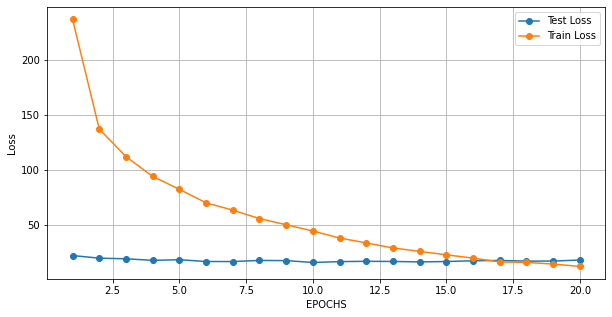

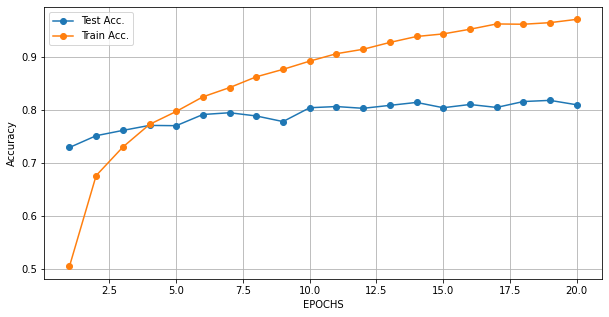

Best Test Acc: 81.83%    (Test Loss: 16.193)


In [ ]:
P_graph(cnn_results[0], cnn_results[1], cnn_results[2], cnn_results[3])
print(f'Best Test Acc: {best_test_acc*100:.2f}%    (Test Loss: {best_test_loss:.3f})')

In [ ]:
sentence = []
sentence.append("차진 식감과 부드러운 감촉을 모두 지닌 식빵, 결결이 찢어지는 크루아상, 둥글고 크게 구운 호밀빵 모두 모양새부터 알차고 단단했다. 디저트로 눈을 옮기면 국가 대표팀같이 뭐 하나 빼놓을 수 없는 케이크가 나란히 줄을 서 있었다.")
sentence.append("정부는 2012년 예산의 공고안과 배정계획을 1월3일 국무회의에서 의결하고 연초부터 바로 집행에 들어간다. 세계 경제의 불확실성이 높아지고 경기가 둔화할 가능성이 높은 만큼 조기 집행에 박차를 가할 예정이다")
sentence.append("국세청은 특히 서민생활에 피해를 주면서 폭리를 취하는 매점매석 농수산물 유통업체 등에 대한 추적조사를 강화하고, 지방청에 ‘민생침해 사업자 조사전담팀’을 꾸려 민생침해 탈세자에 대한 엄정 대응에 나설 계획이라고 밝혔다")
sentence.append("26일 제25회 부산국제영화제 갈라 프레젠테이션 부문 초청작 '스파이의 아내' 온라인 기자회견이 진행됐다. 작품을 연출한 구로사와 감독이 참석해 작품에 대한 이야기를 나눴다.")
sentence.append("70대 운전사가 몰던 25인승 어린이 통학버스가 주유소로 돌진해 차량 3대를 들이 받았다. 다행히 통학버스에 운전자 외에는 탑승자가 없어 큰 인명피해는 피했다. 운전자는 차량 결함을 주장하고 있으나, 경찰은 운전자 과실 여부도 조사 중이다.")
sentence.append("토트넘이 손흥민에게 주급 20만 파운드(약 3억원)-5년 재계약을 제안할 준비를 마쳤다.' 25일(한국시각) 영국 대중일간 더선의 헤드라인이다. 조제 무리뉴 토트넘 감독이 번리전을 앞두고 기자회견을 통해 구단에 토트넘에서의 손흥민의 장밋빛 미래를 확신하며 재계약을 요청한 직후 영국 현지 언론에선 손흥민 재계약 보도가 쏟아지고 있다.")
sentence.append("공연은 말 그대로 다채로움 그 자체였다. 발레극인지, 현대무용극인지, 전통극인지, 연극인지, 연극이면 다인극인지 1인극인지 모를 정도로 다양한 장르의 결합이 먼저 눈에 띈다.")
sentence.append("발이 아프면 걷는 자세가 나빠지고 자연스럽게 무릎, 골반, 허리에 이상이 생길 수 있다. 이를 예방하려면 평소 발바닥 근육을 스트레칭하고 강화하는 운동을 지속하는 게 중요하다.")
sentence.append("전기차 화재 사고가 연이어 발생하는 가운데 불타지 않는 SK이노베이션 배터리가 주목받는다. SK이노베이션의 배터리는 글로벌 배터리 업체 중 유일하게 단 한건의 화재도 일어나지 않았다. 이같은 비결이 자동차 안정성을 결정짓는 분리막 내재화에 있다는 평가가 나온다.")

raw_data = {'Labels': ['생활','정치','경제','문화','사회','스포츠','연예','미용/건강','IT/과학']}

print(predict_news(model_cnn, sentence[0]))
print(predict_news(model_cnn, sentence[1]))
print(predict_news(model_cnn, sentence[2]))

{'Predicted Label': '문화', 'Sentence': '차진 식감과 부드러운 감촉을 모두 지닌 식빵, 결결이 찢어지는 크루아상, 둥글고 크게 구운 호밀빵 모두 모양새부터 알차고 단단했다. 디저트로 눈을 옮기면 국가 대표팀같이 뭐 하나 빼놓을 수 없는 케이크가 나란히 줄을 서 있었다.'}
{'Predicted Label': '경제', 'Sentence': '정부는 2012년 예산의 공고안과 배정계획을 1월3일 국무회의에서 의결하고 연초부터 바로 집행에 들어간다. 세계 경제의 불확실성이 높아지고 경기가 둔화할 가능성이 높은 만큼 조기 집행에 박차를 가할 예정이다'}
{'Predicted Label': '사회', 'Sentence': '국세청은 특히 서민생활에 피해를 주면서 폭리를 취하는 매점매석 농수산물 유통업체 등에 대한 추적조사를 강화하고, 지방청에 ‘민생침해 사업자 조사전담팀’을 꾸려 민생침해 탈세자에 대한 엄정 대응에 나설 계획이라고 밝혔다'}


In [ ]:
# 위의 결과를 표(DataFrame)로 나타내기

result = pd.DataFrame(raw_data)

df = pd.DataFrame()
for s in sentence:
  df = df.append(predict_news(model_cnn, s), ignore_index=True)

result = pd.concat([result,df],axis=1, join='inner')

Accuracy = sum((result['Labels'] == result['Predicted Label'])==True)/len(result) * 100

print("Accuracy = ",round(Accuracy,2),"%")

result

Accuracy =  33.33 %


,Labels,Predicted Label,Sentence
0,생활,문화,"차진 식감과 부드러운 감촉을 모두 지닌 식빵, 결결이 찢어지는 크루아상, 둥글고 크..."
1,정치,경제,정부는 2012년 예산의 공고안과 배정계획을 1월3일 국무회의에서 의결하고 연초부터...
2,경제,사회,국세청은 특히 서민생활에 피해를 주면서 폭리를 취하는 매점매석 농수산물 유통업체 등...
3,문화,문화,26일 제25회 부산국제영화제 갈라 프레젠테이션 부문 초청작 '스파이의 아내' 온라...
4,사회,생활,70대 운전사가 몰던 25인승 어린이 통학버스가 주유소로 돌진해 차량 3대를 들이 ...
5,스포츠,스포츠,토트넘이 손흥민에게 주급 20만 파운드(약 3억원)-5년 재계약을 제안할 준비를 마...
6,연예,문화,"공연은 말 그대로 다채로움 그 자체였다. 발레극인지, 현대무용극인지, 전통극인지, ..."
7,미용/건강,미용/건강,"발이 아프면 걷는 자세가 나빠지고 자연스럽게 무릎, 골반, 허리에 이상이 생길 수 ..."
8,IT/과학,경제,전기차 화재 사고가 연이어 발생하는 가운데 불타지 않는 SK이노베이션 배터리가 주목...
